# Predicting Car Prices with XGBoost

In [3]:
import pandas as pd
cars_df = pd.read_csv('car_price_prediction.csv')
cars_df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
cars_df.drop(["ID"], axis=1, inplace=True)

print(cars_df.info())

<class 'pandas.DataFrame'>
RangeIndex: 19236 entries, 0 to 19235
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19236 non-null  int64  
 1   Levy              19236 non-null  str    
 2   Manufacturer      19236 non-null  str    
 3   Model             19236 non-null  str    
 4   Prod. year        19236 non-null  int64  
 5   Category          19236 non-null  str    
 6   Leather interior  19236 non-null  str    
 7   Fuel type         19236 non-null  str    
 8   Engine volume     19236 non-null  str    
 9   Mileage           19236 non-null  str    
 10  Cylinders         19236 non-null  float64
 11  Gear box type     19236 non-null  str    
 12  Drive wheels      19236 non-null  str    
 13  Doors             19236 non-null  str    
 14  Wheel             19236 non-null  str    
 15  Color             19236 non-null  str    
 16  Airbags           19236 non-null  int64  
dtypes: f

### Report the top 3 Car Manufacturers with the Highest Mean Sales Price

In [5]:
by_manufacturer = cars_df.groupby("Manufacturer") #Group by car manufacturer

by_manufacturer["Price"] # Grab Price Column

avg_price_by_manufacturer = by_manufacturer["Price"].mean() #Calculate mean

avg_price_by_manufacturer.nlargest(3) #Report back top 3 Manufacturers by Mean Sales Price

# We could do this all in one line with pandas
cars_df.groupby("Manufacturer")["Price"].mean().nlargest(3)

Manufacturer
LAMBORGHINI    872946.000000
BENTLEY        197574.500000
OPEL            73305.617128
Name: Price, dtype: float64

### Convert the Mileage Column to a Floating Point Number Type
Currently a few columns are not in numerical format, that means we should convert them before using them in a. machine learning model,in this case XGBoost. 

We'll removing the "km" substring to get numerical values as strings, then convert these strings to a float data type.

In [6]:
cars_df["Mileage"]

def clean_miles(mileage):
    return float(mileage.split(" ")[0])
cars_df["Mileage"] = cars_df["Mileage"].apply(clean_miles)
cars_df["Mileage"]

0        186005.0
1        192000.0
2        200000.0
3        168966.0
4         91901.0
           ...   
19231    300000.0
19232    161600.0
19233    116365.0
19234     51258.0
19235    186923.0
Name: Mileage, Length: 19236, dtype: float64

### Replace the "-" dashes from the Levy Column with Zeros

Currently the Levy column in the dataset is not clean and contains both 0 values and '-'. Use Pandas to clean this column and replace any "-" dashes with a numerical 0 value. Confirm that the column type is then numerical, if not, make sure to convert it to a numerical type.

In [7]:
def clean_levy(value):
    return int(value.replace("-","0"))

cars_df["Levy"] = cars_df['Levy'].apply(clean_levy)

cars_df["Levy"]

0        1399
1        1018
2           0
3         862
4         446
         ... 
19231       0
19232     831
19233     836
19234    1288
19235     753
Name: Levy, Length: 19236, dtype: int64

### Create a Bar Plot Showing the Counts of the Top 10 Most Popular



In [8]:
import matplotlib.pyplot as plt

top_ten_manufacturers = cars_df["Manufacturer"].value_counts().nlargest(10)



<BarContainer object of 10 artists>

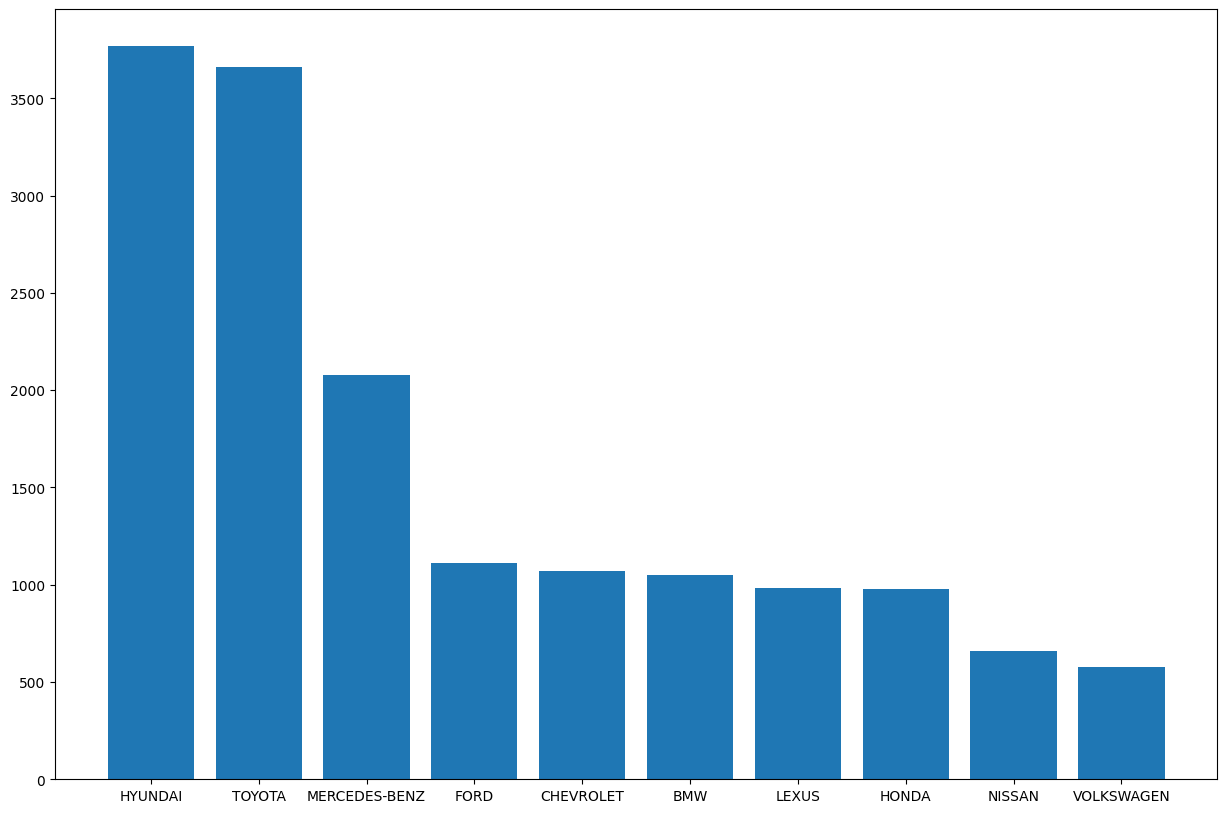

In [9]:
plt.figure(figsize=(15, 10))
plt.bar(x=top_ten_manufacturers.keys(), 
        height=top_ten_manufacturers.values, )

### Analyze Mileage with a Histogram and Remove Outliers

Text(0, 0.5, 'Frequency')

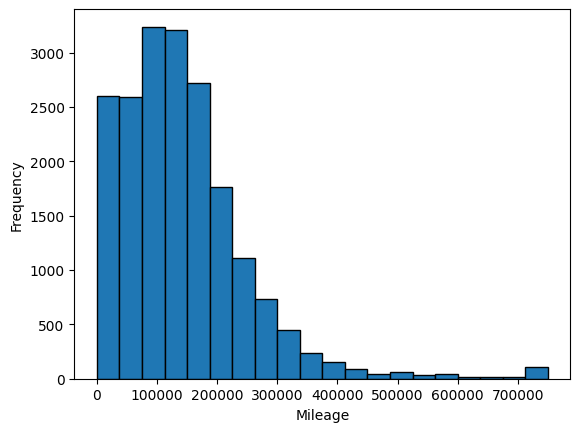

In [10]:
cars_df["Mileage"] = cars_df["Mileage"].clip(lower=0, upper=750000)

plt.figure()
plt.hist(cars_df["Mileage"], edgecolor="black", bins=20)
plt.xlabel("Mileage")
plt.ylabel("Frequency")

### Use One-Hot Encoding to Convert Categorical Features to Numeric Values

In [11]:
categorical_features = cars_df.select_dtypes(include=['object']).columns
one_hot_df = pd.get_dummies(cars_df, columns=categorical_features, )
one_hot_df.head()

/var/folders/cn/212xd04548s0rk0l8ypfc4kw0000gn/T/ipykernel_48481/1188436483.py:1: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_features = cars_df.select_dtypes(include=['object']).columns


,Price,Levy,Prod. year,Mileage,Cylinders,Airbags,Manufacturer_ACURA,Manufacturer_ALFA ROMEO,Manufacturer_ASTON MARTIN,Manufacturer_AUDI,...,Color_Green,Color_Grey,Color_Orange,Color_Pink,Color_Purple,Color_Red,Color_Silver,Color_Sky blue,Color_White,Color_Yellow
0,13328,1399,2010,186005.0,6.0,12,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,16621,1018,2011,192000.0,6.0,8,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,8467,0,2006,200000.0,4.0,2,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3607,862,2011,168966.0,4.0,0,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,11726,446,2014,91901.0,4.0,4,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


### Perform a Train-Test Split on the Data and Train an XGBoost Model to Predict Sales Value

In [12]:
import xgboost
from sklearn.model_selection import train_test_split

In [13]:
data, labels = one_hot_df.drop("Price", axis=1), one_hot_df["Price"]

X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size = 0.2, random_state = 42)

regressor = xgboost.XGBRegressor()
regressor.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

### Use Regression Metrics to Evaluate


In [14]:
from sklearn.metrics import mean_absolute_error

preds = regressor.predict(X_test)
mean_absolute_error(preds, y_test)



5818.89501953125